# Poisson Mapping 

![a](https://img.shields.io/badge/Subject:-Reduction_Processes-blue)
![b](https://img.shields.io/badge/Difficult:-medium-blue)
![c](https://img.shields.io/badge/Author:-Eliza_Diggins-green)

In the pyXMIP package, a special reduction procedure (called ``PoissonPointReduction``) can be used during match reduction. The idea behind this reduction is that, for some object types and databases, there is a chance that (within a given radius) a match to such an object could occur randomly. This probability, which is Poisson distributed, is critical for correctly identifying spurious matches, but it can be difficult to get. In this notebook, we're going to walk through all the ins and outs of Poisson Mapping; the process pyXMIP uses to obtain those probabilities.

## Contents

---

- [Introduction](#Introduction)
  - [Representing Poisson Maps](#Representing-Poisson-Maps)
  - [Poisson Atlases](#Poisson-Atlases)
    - [Building the Counts Table](#The-Counts-Table)
    - [Map HDUs](#Map-HDUs)
  - [Poisson Maps](#Poisson-Maps)
- [Constructing Poisson Maps](#Constructing-Poisson-Maps)
  - [Density Estimation](#Density-Estimation)
    - [Maximum a Posteriori (MAP) Estimation](#Maximum-a-Posteriori-Regression)
    - [K-Nearest Neighbors (KNN) Estimation](#K-Nearest-Neighbor-Regression)
    - [R-Nearest Neighbors (RNN) Estimation](#R-Nearest-Neighbor-Regression) 
---

# Introduction

The Poisson distribution describes the likelihood that a given event with frequency $\omega$ will occur $k$ number of times in a period / space $\Delta$. It takes the form

$$ P(k | \omega,\Delta) = \frac{(\omega \Delta)^{k}\exp\left(-\omega \Delta\right)}{k!}. $$

In the context of pyXMIP, the question becomes "Given a catalog source at some $\textbf{r}$ on the sky and a possible match at $\textbf{r}'$, what's the probability that $\textbf{r}'$ would occur randomly given the type of source and the database it was matched from. Let $\delta$ be the separation on the sky between the two points and $\lambda(\phi,\theta)$ be the **density of that source type** on the sky (specific to the given database). Then the probability that the match happened randomly is

$$ P_{\mathrm{random}}(\textbf{r}'|\textbf{r}) = P_{\mathrm{Poisson}}(k \ge 1 | \delta, \lambda) = 1- \exp\left[-2\pi(1-\cos(\delta))\lambda(\textbf{r})\right] \underbrace{\approx}_{\delta \ll 1} 1- \exp\left[-\pi\delta^2\lambda(\textbf{r})\right].$$

Thus, if we can figure out the **density function** $\lambda(\textbf{r})$, it is actually quite easy to conduct this calculation!

This special function, $\lambda(\textbf{r})$ is called the **Poisson Map** for the given database and source type. A great deal of sophistication has gone into the determination of the Poisson map, but on its surface, its a relatively simple idea!

---

## Representing Poisson Maps

![](https://healpix.jpl.nasa.gov/images/healpixGridRefinement.jpg)

The first step in representing functions on the sky is to determine how we're going to store them for interpolation. On a Euclidean space, this is a relatively simple undertaking: we just use a grid. On a spherical surface, it's not quite as simple. 

The solution used in pyXMIP is what are called HEALPix grids. HEALPix is a scheme for breaking up the sky into tiles of equal area so that the entire sky is covered. You can read more details about HEALPix [here](https://healpix.jpl.nasa.gov/). For our uses, there are a few key things worth knowing.

![](https://healpix.jpl.nasa.gov/images/exampleEarthTopo.jpg)![](https://healpix.jpl.nasa.gov/images/exampleCMB.jpg)

- HEALPix grids may have any of a number of different resolutions. This is dictated by the $N_{\mathrm{side}}$ parameter
  $$ N_{\mathrm{side}} = 2^k, \; k\in \mathbb{N}$$

- The area of a given tile is

  $$ \Omega_{\mathrm{pix}} = \theta_{\mathrm{pix}}^2 = \frac{3}{\pi} \left(\frac{1.097 \mathrm{sr}}{N_{\mathrm{sides}}^2}\right) $$
  
## Poisson Atlases

The ``PoissonAtlas`` class is the critical class for representing sets of Poisson maps. On its surface, ``PoissonAtlas`` instances simply wrap ``.fits`` files containing 2 sets of extensions:

- A ``BinTable`` extension ``COUNTS`` (only 1)
  - The ``COUNTS`` is built by randomly sampling from points on the sky. For each point, the database is queried for all the objects within angular
    radius $\delta$. The numbers of each object type are then counted and written to the ``COUNTS`` table. This is the raw data that eventually becomes     a Poisson map.
    
- ``ImageArray`` extensions with the names of different types of astronomical objects. (As may as there are object types).
  - Each of these ``ImageArray`` objects is a $1\times N_{\mathrm{pix}}$ array containing the finished Poisson maps once we have completed the process      of calculating them.

From the ``PoissonAtlas`` class, you can add points to ``COUNTS``, re-construct a Poisson map on disk, or extract a map for use. This tutorial will show all of these things.

In [3]:
from pyXMIP.structures.databases import SIMBAD, NED
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from rich.pretty import (
    pprint as print,
)  # This can be skipped if you don't have rich installed.

# -- Opening the atlases attached to two of our database classes -- #

ned_atlas, simbad_atlas = NED.get_poisson_atlas(), SIMBAD.get_poisson_atlas()
print(
    f"There are {len(ned_atlas.get_points())} count entries in NED and {len(simbad_atlas.get_points())} in SIMBAD."
)

'There are 1400 count entries in NED and 2800 in SIMBAD.'

### The Counts Table

The first stage in generating maps is to fill the ``COUNTS`` table in a given atlas. In pyXMIP, all of the available remote databases (SIMBAD, NED, etc.) already have built-in ``PoissonAtlas`` instances with large ``COUNTS`` tables; however, it is sometimes advantageous to add new points, or reset a table. Additionally, if you are generating a ``PoissonAtlas`` from scratch, the ``COUNTS`` table will have to be generated.

To start, let's take a look at an existing ``COUNTS`` table:

In [4]:
ned_atlas.get_points()[:5]

<Table length=5>
  *     **   *Ass  *Cl  ...   RAD             TIME           PIX_ID
int64 int64 int64 int64 ... float64          str24           int64 
----- ----- ----- ----- ... ------- ------------------------ ------
    9     0     0     0 ...     1.0 Sat Apr 13 16:42:42 2024   4604
    0     0     0     0 ...     1.0 Sat Apr 13 16:42:42 2024  12712
    0     0     0     0 ...     1.0 Sat Apr 13 16:42:42 2024   7287
    0     0     0     0 ...     1.0 Sat Apr 13 16:42:42 2024   4524
    2     0     0     0 ...     1.0 Sat Apr 13 16:42:42 2024   4478

As you can see there are a bunch of columns corresponding to each of the recognized object types in the given database. In this case, we're looking at IPAC-NED, so there are quite a number of object types. In each row, the number represents the **number of objects in the point sample**. Information about the point sample is contained in the final 5 columns. ``RAD`` provides the size of the sample area (radius in arcmin), and ``PIX_ID`` corresponds to the HEALPix location of that search. 

What if we want to add more points to our atlas to improve the statistics? That's easily achieved:

In [5]:
import astropy.units as u

# Adding new points to the PoissonAtlas instances.
#
# 300 -> number of samples, 1 arcmin -> size of search area, thread_kw -> threaded querying for speed.
#
ned_atlas.sample_from_database(
    300, 1 * u.arcmin, thread_kw={"max_workers": 50, "chunk_size": 20}
)
simbad_atlas.sample_from_database(
    500, 1 * u.arcmin, thread_kw={"max_workers": 30, "chunk_size": 20}
)

pyXs : [INFO     ] 2024-04-13 23:05:10,986 Adding 300 counting queries to /home/ediggins/pyXs/pyXMIP/bin/psn_maps/NED.poisson.fits atlas.
pyXs : [DEBUG    ] 2024-04-13 23:05:10,990 LINKED DATABASE: <class 'pyXMIP.structures.databases.NED'>
pyXs : [INFO     ] 2024-04-13 23:05:10,992 Querying for 300 random counts on NED.
pyXs : [DEBUG    ] 2024-04-13 23:05:11,001 Querying with threading.
100%|██████████| 300/300 [00:19<00:00, 15.42it/s]
pyXs : [INFO     ] 2024-04-13 23:05:30,592 Appended 300 samples to COUNTS.
pyXs : [INFO     ] 2024-04-13 23:05:30,593 Adding 500 counting queries to /home/ediggins/pyXs/pyXMIP/bin/psn_maps/SIMBAD.poisson.fits atlas.
pyXs : [DEBUG    ] 2024-04-13 23:05:30,595 LINKED DATABASE: <class 'pyXMIP.structures.databases.SIMBAD'>
pyXs : [INFO     ] 2024-04-13 23:05:30,596 Querying for 500 random counts on SIMBAD.
pyXs : [DEBUG    ] 2024-04-13 23:05:30,597 Querying with threading.
100%|██████████| 500/500 [00:26<00:00, 18.59it/s]
pyXs : [INFO     ] 2024-04-13 23:05:

In [6]:
print(
    f"There are {len(ned_atlas.get_points())} count entries in NED and {len(simbad_atlas.get_points())} in SIMBAD."
)

'There are 1700 count entries in NED and 3300 in SIMBAD.'

We can also get a general idea of the point densities by directly accessing the tables:

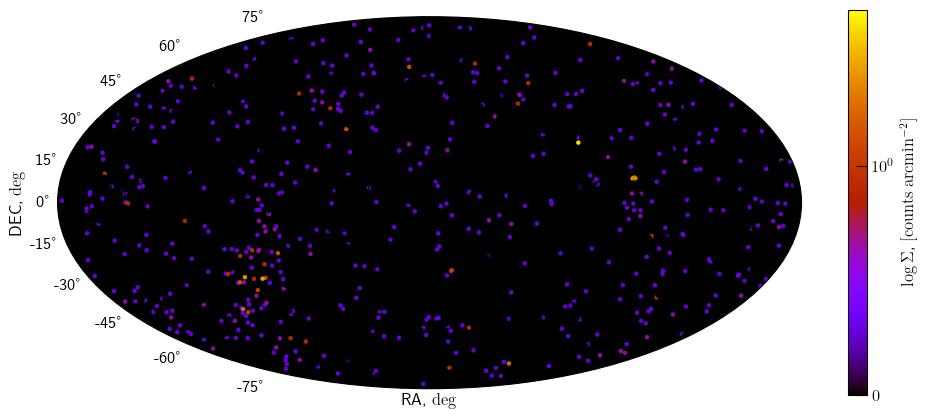

In [7]:
from pyXMIP.utilities.geo import convert_skycoord
from pyXMIP.utilities.plot import set_style
from astropy.coordinates import SkyCoord
from matplotlib.colors import SymLogNorm

set_style()  # --> Enforce pyXMIP custom style guide.

# -- pull a default poisson map's data -- #
atlas = SIMBAD.get_default_poisson_atlas()

# Fetch the point data.
point_data = atlas.get_points()

# -- pull the raw point data out of the map -- #
x, y, N, R = point_data["RA"], point_data["DEC"], point_data["*"], point_data["RAD"]
positions = SkyCoord(ra=x, dec=y, unit="deg")
density = N / (np.pi * (R**2))

# --> convert the sky positions to the convention for plotting in matplotlib.
x, y = convert_skycoord(positions, "latlon")

# -- plot -- #
figure = plt.figure(figsize=(12, 5))
ax = figure.add_subplot(111, projection="mollweide")
ax.set_facecolor("k")
norm = SymLogNorm(vmin=0, vmax=np.amax(density), linthresh=1)
cmap = plt.cm.gnuplot

ax.scatter(x, y, c=cmap(norm(density)), s=5, alpha=0.85)

plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    label=r"$\log \Sigma$, $\left[\mathrm{counts\; arcmin^{-2}}\right]$",
)
_ = ax.set_xlabel(r"RA, $\mathrm{deg}$")
_ = ax.set_ylabel("DEC, $\mathrm{deg}$")

So far so good! We've seen how the ``COUNTS`` table works and how we can plot it, now it's time to explore what we can do with it in the long-run.

### Map HDUs

For the sake of completeness, it's worth briefly mentioning the other component of a ``SkyAtlas`` (the parent class of ``PoissonAtlas``): ``MapHDU``s. 

For those unfamiliar with the ``fits`` file format, ``HDU`` are **Heirarchical Data Units**, and store data in the ``fits`` system. We've already encountered one: ``COUNTS``. The other HDU's in the ``PoissonAtlas`` file are actually images; more accurately, they're ``HEALPix`` maps. We can load them as ``Map`` classes to use for various useful processes as discussed below. For now, we'll simply show some basic properties of them.

In [8]:
# Accessing properties of the HEALPix grids:
atlas = SIMBAD.get_poisson_atlas()
print(
    f"The SIMBAD atlas has N={atlas.NPIX} pixels, corresponding to N_SIDES={atlas.NSIDE}."
)

# What maps are available?
print(f"There are {len(atlas.map_names)} map(s): {atlas.map_names}.")

# What's the native coordinate system of this object?
print(f"The native coordinate system is {atlas.CSYS}")

'The SIMBAD atlas has N=13872 pixels, corresponding to N_SIDES=34.'

"There are 1 map(s): ['*']."

'The native coordinate system is ICRS'

---

## Poisson Maps

We're now well and truly aquainted with the ``PoissonAtlas`` class; it's now time to meet it's constituent class: ``Map``.

The ``Map`` class is effectively a **function on the sky**. In the backend, it turns a ``HEALPix`` grid into a callable function! Let's explore some
of the simpler functionality of these maps to get aquainted.


In [9]:
atlas = NED.get_poisson_atlas()

# What maps are available?
print(f"The available maps are {atlas.map_names}")

# load a map
irs_map = atlas.get_map("IrS")

"The available maps are ['*', 'UVS', 'IRS']"

pyXs : [DEBUG    ] 2024-04-13 23:05:59,026 Loading Map object from /home/ediggins/pyXs/pyXMIP/bin/psn_maps/NED.poisson.fits [Name=IRS].


Just like ``Atlas`` types, ``Map`` types have the typical ``HEALPix`` parameters:

In [10]:
print(
    f"The NED IrS has N={irs_map.NPIX} pixels, corresponding to N_SIDES={irs_map.NSIDE}."
)
print(f"The NED IrS map was last edited on {irs_map.ED}.")
# print(f"The NED IrS map was building using {irs_map.METH}.")

'The NED IrS has N=13872 pixels, corresponding to N_SIDES=34.'

'The NED IrS map was last edited on Sat Apr 13 22:25:41 2024.'

Let's consider an example. At $\mathrm{RA} = 0 \;\mathrm{rad}$ and $\mathrm{DEC} = 0\; \mathrm{rad}$, what's the likelihood of finding 3 IrS sources within an area of radius $\delta = 5\; \mathrm{arcmin}$?

$$ P(k=3,\phi_0,\theta_0,\delta) = (\pi\delta^2 \lambda(\phi_0,\theta_0))^{3} \exp\left(-\pi\delta^2 \lambda(\phi_0,\theta_0)\right) / 3! $$

In [11]:
position = SkyCoord(ra=0, dec=0, unit="rad")

# compute the density
density = irs_map(position)
print(f"The density at (0,0) is {np.round(density,decimals=3)} counts / arcmin^2")

# area
rate = np.pi * (5) ** 2 * density

# value
prob = (rate**3) * np.exp(-rate) / (6)

print(f"The probability is {prob}. The expected value is {rate}.")

0.0 1.5707963267948966


'The density at (0,0) is 2.944 counts / arcmin^2'

'The probability is 7.815837430702794e-95. The expected value is 231.22788344826247.'

You can also visualize maps quite easily. Let's look at a simple example:

In [53]:
# -- fetch an atlas -- #
atlas = NED.get_poisson_atlas()

# -- build a map -- #
psn_map = atlas.build_poisson_map(
    "IrS",
    method="RNN",
    training_kw={"training_fraction": 0.75},
    param_kw={"radius": [0.5, 0.6, 0.7, 0.8, 1, 2], "weights": ["distance"]},
    inplace=True,
)

pyXs : [INFO     ] 2024-04-13 23:32:17,783 Generating IrS map using RNN.
pyXs : [DEBUG    ] 2024-04-13 23:32:17,822 Cross-validating <pyXMIP.stats.map_regression.RNNeighborMapRegressor object at 0x7f8b1a04f590>.
pyXs : [DEBUG    ] 2024-04-13 23:32:18,311 CROSS-VALIDATED IrS. PARAMS:
pyXs : [DEBUG    ] 2024-04-13 23:32:18,312 radius = 0.5
pyXs : [DEBUG    ] 2024-04-13 23:32:18,312 weights = distance
pyXs : [DEBUG    ] 2024-04-13 23:32:18,316 Training RadiusNeighborsRegressor(metric='haversine', radius=0.5, weights='distance') on 1275 data-points


We can now access the map we generated:

pyXs : [DEBUG    ] 2024-04-13 23:32:19,471 Loading Map object from /home/ediggins/pyXs/pyXMIP/bin/psn_maps/NED.poisson.fits [Name=IRS].


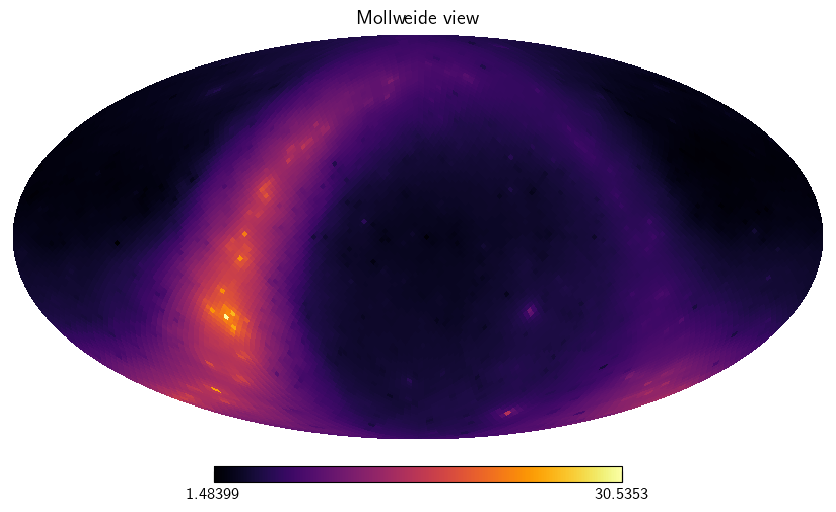

In [54]:
map = atlas.get_map("IrS")

import healpy as hp

hp.mollview(map.data, flip="geo")
plt.show()

We can also change the coordinate system if we want:

[-2.89069807 -2.92286377 -2.94347106 ...  0.23001574  0.25089458
  0.21872889] [1.09244016 1.0738412  1.1024804  ... 2.02078292 2.04915249 2.06775146]


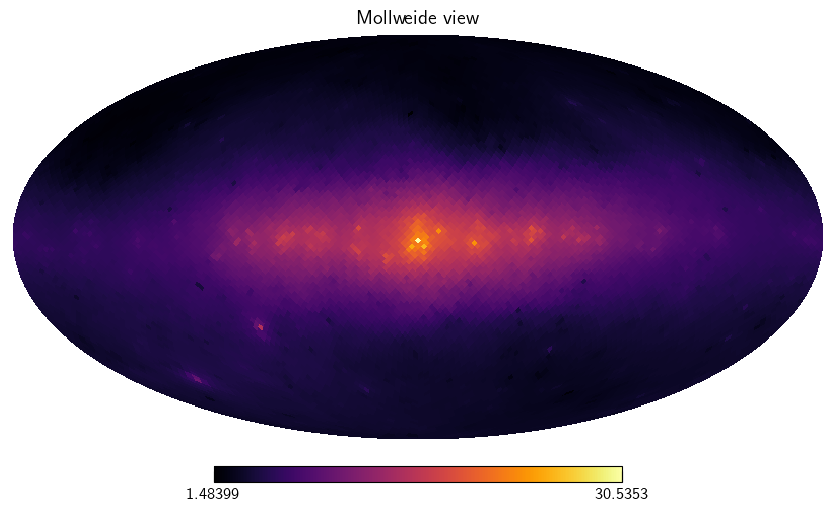

In [55]:
map.transform_map_coordinates("Galactic", inplace=True)

hp.mollview(map.data, flip="geo")
plt.show()

---

# Constructing Poisson Maps

---

![d](https://img.shields.io/badge/Difficult:-tricky-orange)

For most basic uses, the information presented is already more than sufficient. For the most part, Poisson maps are drawn upon behind the scenes and don't need to be messed with. There are some scenarios in which you'll need a more sophisticated understanding:

- Creating your own databases with linked Poisson Atlases.
- Fine-grain control of the statistics.
- Further development.

In this section, we're going to discuss the nitty-gritty of generating Poisson maps.

## Density Estimation

As described above, ``PoissonAtlas`` objects have a ``COUNTS`` table with the Poisson counts data. The question becomes how we generate the corresponding Poisson maps given these samples. This problem is an example of a generic set of problems known as density estimation problems. PyXMIP provides for a variety of different approaches which are summarized below.

To begin, let's get a visual sense of what needs to happen. To start, let's open the ``SIMBAD`` ``PoissonAtlas`` class and look at the distribution of points.

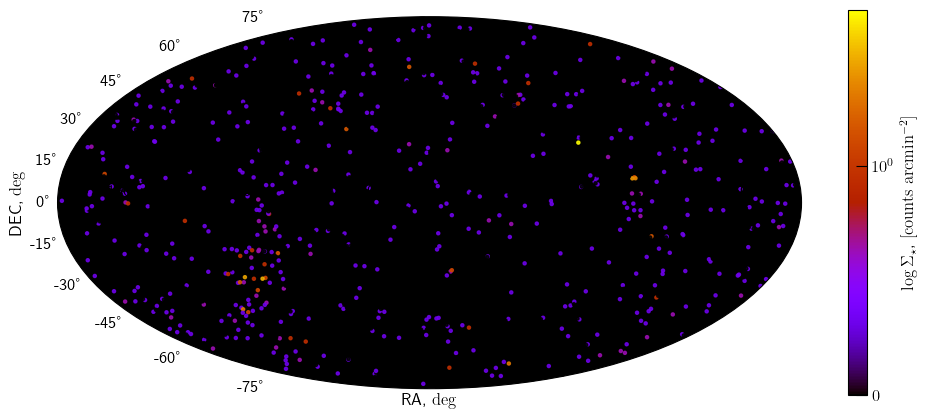

In [12]:
from pyXMIP.utilities.geo import convert_skycoord
from pyXMIP.utilities.plot import set_style
from astropy.coordinates import SkyCoord
from matplotlib.colors import SymLogNorm

set_style()  # --> Enforce pyXMIP custom style guide.

# -- pull a default poisson map's data -- #
atlas = SIMBAD.get_default_poisson_atlas()

# Fetch the point data.
point_data = atlas.get_points()

# -- pull the raw point data out of the map -- #
x, y, N, R = point_data["RA"], point_data["DEC"], point_data["*"], point_data["RAD"]
positions = SkyCoord(ra=x, dec=y, unit="deg")
density = N / (np.pi * (R**2))

# --> convert the sky positions to the convention for plotting in matplotlib.
x, y = convert_skycoord(positions, "latlon")

# -- plot -- #
figure = plt.figure(figsize=(12, 5))
ax = figure.add_subplot(111, projection="mollweide")
ax.set_facecolor("k")
norm = SymLogNorm(vmin=0, vmax=np.amax(density), linthresh=1)
cmap = plt.cm.gnuplot

ax.scatter(x, y, c=cmap(norm(density)), s=5, alpha=0.85)

plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    label=r"$\log \Sigma_\star$, $\left[\mathrm{counts\; arcmin^{-2}}\right]$",
)
_ = ax.set_xlabel(r"RA, $\mathrm{deg}$")
_ = ax.set_ylabel("DEC, $\mathrm{deg}$")

Based on this plot, it's quite clear that the stellar density peaks around the galactic plane (as one would expect!). The problem is that, for a HEALPix grid of this size, we're likely to always have some blank spots. What we'd like to do is interpolate these points over the entire sphere to get a smooth distribution of points.

PyXMIP implements a variety of methods for doing this:

**Map Generation Methods**:

- [Maximum A Posteriori (MAP)](#Maximum-A-Posteriori-(MAP))

---

### Maximum A Posteriori Regression

Maximum *a posteriori* estimation is a **Bayesian** technique which provides **point-estimates** for the correct poisson density $\lambda(\phi,\theta)$ at each of the ``HEALPix`` cells.

Under the hood, MAP is actually quite complex because (depending on what information the user provides), it can either be very easy of quite difficult. There are two key-word arguments that can be passed with the MAP method:

- ``model``: A ``callable``  $f(\phi,\theta;\mathbf{\Theta})$, where $\mathbf{\Theta}$ is a vector of additional parameters.
  - The ``model`` kwarg allows the user to get a Baysian fit to the Poisson distribution with
    $$ \lambda(\phi,\theta) = f(\phi,\theta,\mathbf{\Theta}_{\mathrm{MAP}}). $$
    This may be useful if you're confident you know the model $f$ and you want to use that as a constraint on the resulting map.
  - When in use, this leads to a non-local Bayesian solver because we are now no longer able to address the problem cell-by-cell.
  - **Not Yet Implemented**
 
    
- ``prior``: A ``callable`` function $p(\phi,\theta,\mathbf{\Theta})$ which provides the spatially variable prior for the parameters $\mathbf{\Theta}$.
  - **Not Yet Implemented**


**Pros and Cons**:

- *Pros*:
  - Very quick method and easy to check that things make sense.
  - No need for training or cross validation. No fiddling necessary.
  - Allows a robust confidence interval on $\lambda$.
- *Cons*:
  - Local (when ``model=None``). Thus, only useful when ``COUNTS`` is quite large.
  - Requires complex, non-linear methods to solve when either ``prior`` or ``model`` is specified. 


**Usage**:

Let's take a look at a very simple example without priors or a model:

In [27]:
atlas = SIMBAD.get_default_poisson_atlas()
psn_map = atlas.build_poisson_map("*", method="MAP", inplace=False)

pyXs : [INFO     ] 2024-04-13 23:09:11,580 Generating * map using MAP.
pyXs : [DEBUG    ] 2024-04-13 23:09:11,662 Building MAP estimate for <pyXMIP.stats.map_regression.BayesianPoissonMapRegressor object at 0x7f8b48476cd0>.
pyXs : [DEBUG    ] 2024-04-13 23:09:11,662 MAP estimator -- ANALYTIC [no p, no m]


Computing MAP estimate (ANYTC):   0%|          | 0/33 [00:00<?, ?it/s]

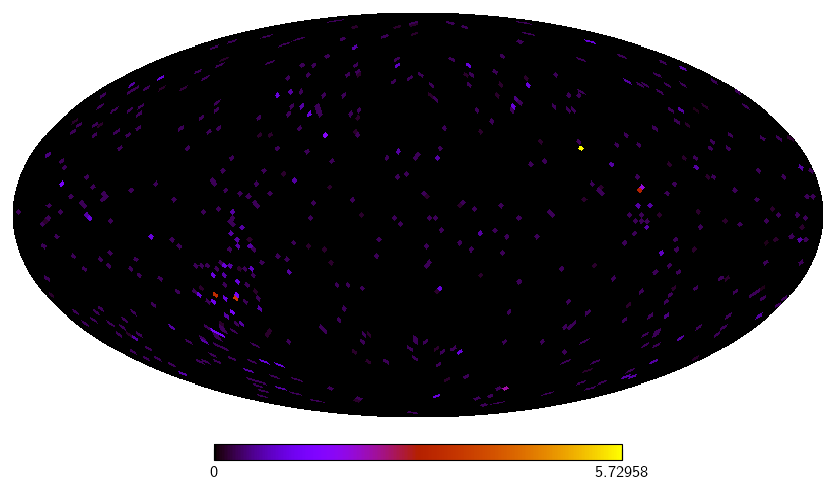

In [38]:
import healpy as hp

hp.mollview(psn_map.map, cmap="gnuplot", title="", flip="geo")
plt.show()

MAP is really at it's best for very common object types:

pyXs : [INFO     ] 2024-04-13 23:15:28,037 Generating IrS map using MAP.
pyXs : [DEBUG    ] 2024-04-13 23:15:28,075 Building MAP estimate for <pyXMIP.stats.map_regression.BayesianPoissonMapRegressor object at 0x7f8b1a57c850>.
pyXs : [DEBUG    ] 2024-04-13 23:15:28,076 MAP estimator -- ANALYTIC [no p, no m]


Computing MAP estimate (ANYTC):   0%|          | 0/17 [00:00<?, ?it/s]

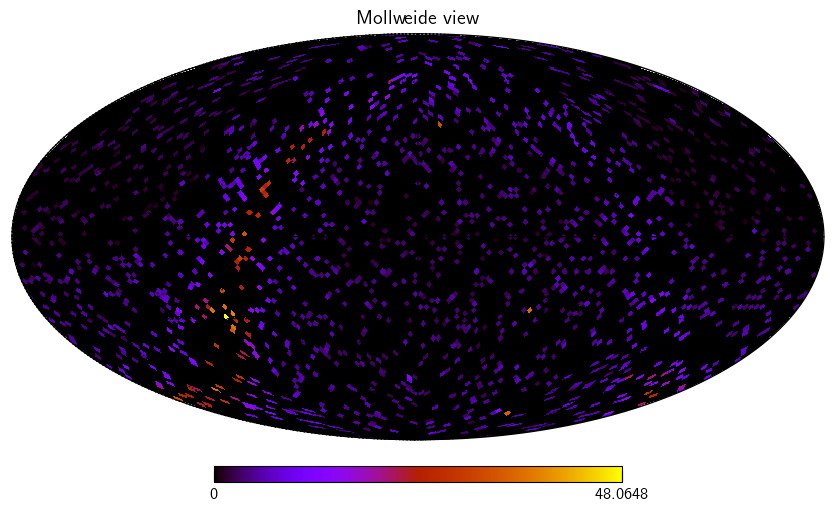

In [41]:
# -- pull a default poisson map's data -- #
from pyXMIP.structures.databases import NED

atlas = NED.get_default_poisson_atlas()
psn_map = atlas.build_poisson_map("IrS", method="MAP", inplace=False)

import healpy as hp

hp.mollview(psn_map.map, cmap="gnuplot", flip="geo")
hp.graticule()
plt.show()

So now we can see what's going on here. The MAP estimator is a point-estimate, it doesn't smooth the map. This doesn't mean that it's not useful. If you have a rich enough set of data, it might be one of the most accurate options!

---

### K-Nearest Neighbor Regression

The $k$-nearest neighbors approach (KNN) is a fully implemented machine learning approach to density estimation. We highly suggest you read the API documentation on all of the options.

In general terms, KNN can be implemented with between 1 and 3 steps:

- **Cross-Validation**: Controlled by the ``cross-validatate`` kwarg. If ``True``, then a portion of the training set is held for cross-validation of
  the relevant hyper-parameters. In this case, ``n_neighbors`` or ``weights``.
  - CV parameters can be provided in ``training_kw`` and the parameter grid to run the CV on is specified in ``param_kw``.
 
- **Training**: Fits the regressor to the available data. Additional training kwargs are added via ``training_kw``.
  - The most useful kwarg is ``training_fraction``, which determines what fraction of the available data is used for training versus testing.

- **Interpolation**: Use the fitted model to interpolate over all of the ``HEALPix`` grids.


It should be noted that you can also enforce a ``score_threshold`` or ``cv_threshold`` to require a specific score before allowing the process to proceed. Additionally ``inplace=False`` allows you to validate the map without it being written immediately to the underlying ``.fits`` file.

In [42]:
# -- fetch the atlas -- #
atlas = NED.get_poisson_atlas()

# -- build the Poisson Map -- #
psn_map = atlas.build_poisson_map(
    "IrS",  # The object type to model.
    method="KNN",  # Method to use: KNN
    training_kw={"training_fraction": 0.5},  # training kwargs.
    param_kw={
        "n_neighbors": [3, 4, 5, 6],
        "weights": ["distance"],
    },  # parameter kwargs.
    inplace=False,  # Not writing to .fits
)

pyXs : [INFO     ] 2024-04-13 23:23:39,749 Generating IrS map using KNN.
pyXs : [DEBUG    ] 2024-04-13 23:23:39,813 Cross-validating <pyXMIP.stats.map_regression.KNNeighborMapRegressor object at 0x7f8b1bb9ee90>.
pyXs : [DEBUG    ] 2024-04-13 23:23:39,926 CROSS-VALIDATED IrS. PARAMS:
pyXs : [DEBUG    ] 2024-04-13 23:23:39,926 n_neighbors = 6
pyXs : [DEBUG    ] 2024-04-13 23:23:39,927 weights = distance
pyXs : [DEBUG    ] 2024-04-13 23:23:39,939 Training KNeighborsRegressor(metric='haversine', n_neighbors=6, weights='distance') on 850 data-points


**That was easy!** Let's take a look at why pyXMIP is telling us:

- The first logging output tells us that we're generating a KNN map of object type *.
- The first thing that happens is that the regression model is cross-validated to determine the optimal number of neighbors $n$ to use.
- Then the model trains against the data.

Now, let's investigate what came out of this!

In [38]:
# look at the output from the map!
print(psn_map)

namespace(map=array([4.58179432, 4.43984073, 4.71969866, ..., 4.70693879, 5.06894115,
│      4.79061815]), method='KNNeighborMapRegressor')

**NOTE**: if you set ``inplace=True``, then the map will be written directly to disk and you will need to retrieve it with ``atlas.get_map('*')``. In some cases, you may just want to get the HEALPix grid back immediately, in which case, you can use ``inplace=False``.

Let's go ahead and look at this map!

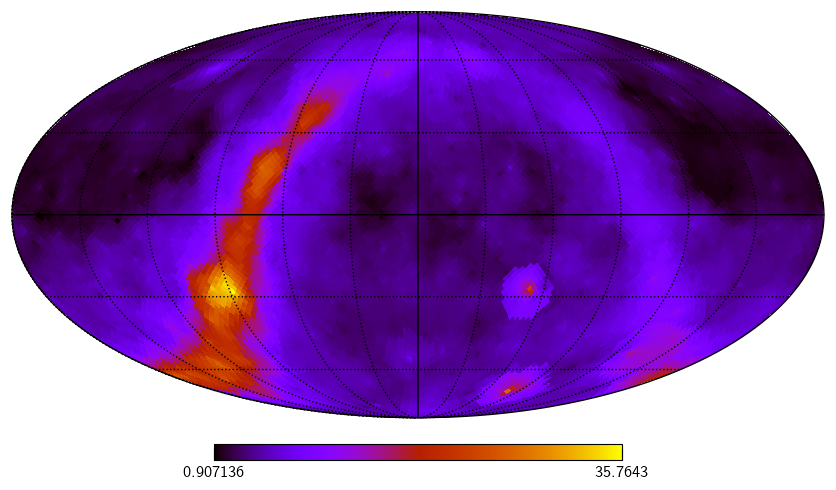

In [47]:
import healpy as hp

d = psn_map.map
hp.mollview(d, cmap="gnuplot", flip="geo", notext=True, title="")
hp.graticule()
plt.show()

---

### R-Nearest Neighbor Regression

R-Nearest Neightbor Regression (RNN) is very similar to KNN but with a minor twist: RNN uses a constant circular size to search for points instead of finding it's nearest neighbors. All of the parameters are the same except instead of ``n_neighbors``, we now use ``radius``.


pyXs : [INFO     ] 2024-04-13 23:27:31,666 Generating IrS map using RNN.
pyXs : [DEBUG    ] 2024-04-13 23:27:31,915 Cross-validating <pyXMIP.stats.map_regression.RNNeighborMapRegressor object at 0x7f8b1ac7b950>.
pyXs : [DEBUG    ] 2024-04-13 23:27:32,489 CROSS-VALIDATED IrS. PARAMS:
pyXs : [DEBUG    ] 2024-04-13 23:27:32,490 radius = 0.5
pyXs : [DEBUG    ] 2024-04-13 23:27:32,491 weights = distance
pyXs : [DEBUG    ] 2024-04-13 23:27:32,497 Training RadiusNeighborsRegressor(metric='haversine', radius=0.5, weights='distance') on 850 data-points


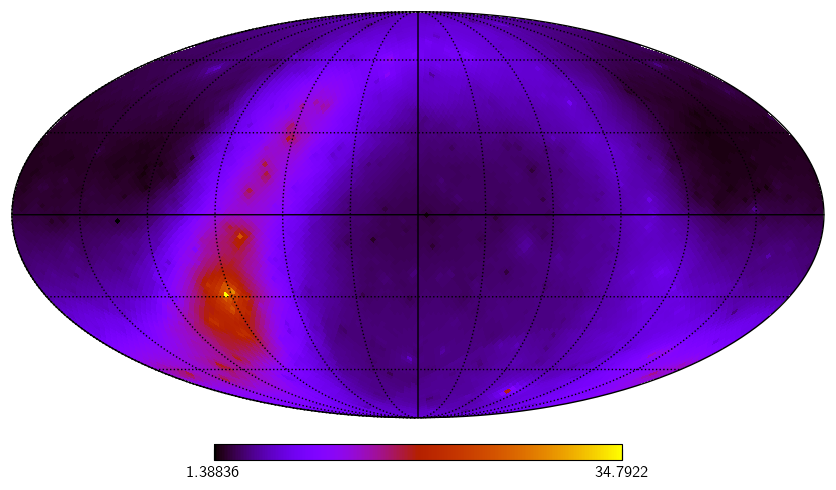

In [48]:
atlas = NED.get_poisson_atlas()
psn_map = atlas.build_poisson_map(
    "IrS",
    method="RNN",
    training_kw={"training_fraction": 0.5},
    param_kw={"radius": [0.5, 0.6, 0.7, 0.8, 1, 2], "weights": ["distance"]},
    inplace=False,
)
import healpy as hp

hp.mollview(psn_map.map, cmap="gnuplot", flip="geo", notext=True, title="")
hp.graticule()
plt.show()